# Prophet Model #


In [9]:
# In this code block we Import the necessary libraries required for our Model 
import yfinance as yf
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


- **yfinance**: We Import this library as thi is  used for fetching historical market data from Yahoo Finance. In this case, it will help retrieve stock price data for analysis.
  
- **pandas**: Pandas is a data manipulation library  used for handling tabular data, cleaning, and organizing datasets.

- **numpy**: Numpy is a library for numerical operations and used for working with arrays and performing mathematical functions.

- **vaderSentiment**: This Library is Imported to Provide a sentiment analysis tool, `SentimentIntensityAnalyzer`, which is specifically optimized for social media text and general-purpose sentiment scoring. This is Useful for analyzing textual data to derive sentiment scores for financial analysis.

- **sklearn.preprocessing.StandardScaler**: sklearn is used for Standardizing features by removing the mean and scaling to unit variance, making data distribution more suitable for model training.

- **prophet**: A forecasting library by Facebook (now Meta) that is optimized for time series data with seasonal effects and missing data. It decomposes data into trend, seasonality, and holiday components, useful for financial forecasting.

- **sklearn.metrics**: Provides performance metrics for model evaluation, including:
  - `mean_squared_error` (RMSE) and `mean_absolute_error` (MAE): To evaluate the prediction error in continuous data.
  - `r2_score`: Measures the proportion of the variance explained by the model, indicating model fit quality.
  - `precision_score`, `recall_score`, `accuracy_score`, and `f1_score`: Classification metrics, especially useful for evaluating directional accuracy in financial time series.

- **matplotlib.pyplot**: A plotting library for creating visualizations to analyze data patterns, trends, and model results.

- **seaborn**: A data visualization library based on Matplotlib that provides a high-level interface for creating visually attractive statistical graphics.                                

In [10]:

# Step 1: Fetch Sage PLC and FTSE 100 data
stock_ticker_symbol = 'SGE.L'
ticker_data = yf.Ticker(stock_ticker_symbol)
stock_ticker = ticker_data.history(period='1d', start='2013-01-01', end='2024-11-01')

FTSE_data = yf.download("^FTSE", start="2013-01-01", end="2024-11-01")
FTSE_data = FTSE_data.rename(columns={'Close': 'FTSE_Close'})

# Convert DateTime indexes to timezone-naive
stock_ticker.index = stock_ticker.index.tz_localize(None)
FTSE_data.index = FTSE_data.index.tz_localize(None)


[*********************100%***********************]  1 of 1 completed


# Data Collection 

1. **Define Ticker Symbol for Sage PLC**:
   - `ticker_symbol = 'SGE.L'`: This Specifies the stock ticker symbol for Sage PLC on the London Stock Exchange.

2. **Fetch Sage PLC Data**:
   - `ticker_data = yf.Ticker(ticker_symbol)`: We Initialize a Ticker object for Sage PLC using `yfinance`.
   - `stock_ticker = ticker_data.history(period='1d', start='2013-01-01', end='2024-11-01')`: We are Retrieving historical daily price data for Sage PLC from January 1, 2013, to November 1, 2024 as this particular date range provides a comprehensive dataset that captures diverse economic cycles, significant market events, and recent trends, offering a balanced view for robust model training and evaluation.

3. **Fetch FTSE 100 Data**:
   - `ftse_data = yf.download("^FTSE", start="2013-01-01", end="2024-11-01")`: We Download historical daily data for the FTSE 100 index within the same date range.
   - `ftse_data = ftse_data.rename(columns={'Close': 'FTSE_Close'})`: Renames the "Close" column in the FTSE data to "FTSE_Close" for clarity and easier identification when merged with Sage PLC data.

4. **Convert DateTime Indexes to Timezone-Naive**:
   - `stock_ticker.index = stock_ticker.index.tz_localize(None)` and `ftse_data.index = ftse_data.index.tz_localize(None)`: Removes timezone information from the DateTime indexes for both Sage PLC and FTSE 100 data to ensure compatibility during further data processing and merging.

In [11]:

# Step 2: In this Step we Merge FTSE data into the stock_ticker variable on date index
stock_ticker = stock_ticker.merge(FTSE_data[['FTSE_Close']], left_index=True, right_index=True, how='left')

# Step2.1: In this step we handle missing values by applying linear interpolation to fill any gaps in data, followed by forward filling too.
stock_ticker['FTSE_Close'] = stock_ticker['FTSE_Close'].interpolate(method='linear').fillna(method='ffill')
stock_ticker['Close'] = stock_ticker['Close'].fillna(method='ffill')

/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_48123/25773050.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_ticker['FTSE_Close'] = stock_ticker['FTSE_Close'].interpolate(method='linear').fillna(method='ffill')
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_48123/25773050.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_ticker['Close'] = stock_ticker['Close'].fillna(method='ffill')


# Step 2: Merge FTSE Data into `stock_ticker` and Handle Missing Values

In this step, we merge the FTSE 100 index data (`ftse_data`) into the main stock price DataFrame (`stock_ticker`) based on the date index to align both datasets.

1. **Merging FTSE Data**: 
   - We merge the `FTSE_Close` column from `ftse_data` into `stock_ticker` using a left join on the date index.
   - This alignment allows us to incorporate FTSE index data as a contextual feature for stock price predictions.

2. **Handling Missing Values**:
   - For `FTSE_Close`, we apply linear interpolation to fill any gaps in data, followed by forward filling (`fillna(method='ffill')`) to ensure continuity.
   - For the main stock `Close` column, we use forward filling to handle missing values, ensuring the data remains uninterrupted.

This preprocessing step ensures a consistent dataset with complete FTSE and stock price information, ready for analysis and model training.


In [12]:
# Step 3: In this step we Conduct Sentiment Analysis on Synthetic Data related to Sage stock
Sentiment_Analyzer = SentimentIntensityAnalyzer()
Sentiment_text_data_to_be_analyzed = [
    "The stock of Sage is performing well",
    "There are concerns about market volatility for Sage",
    "Sage reported strong quarterly earnings",
    "Uncertainty around the global economy is rising and affecting Sage",
    "New innovations are driving stock growth for Sage"
]

stock_ticker['Text'] = (Sentiment_text_data_to_be_analyzed * (len(stock_ticker) // len(Sentiment_text_data_to_be_analyzed) + 1))[:len(stock_ticker)]
stock_ticker['Sentiment'] = stock_ticker['Text'].apply(lambda x: Sentiment_Analyzer.polarity_scores(x)['compound'])

# Step 3: Conducting Sentiment Analysis on Synthetic Data

 Sentiment analysis is performed on a set of synthetic statements related to Sage stock. We use the `SentimentIntensityAnalyzer` from the VADER sentiment analysis library to evaluate the sentiment of each statement. Lets Breakdown the process as follow:

1. **Initializing the Sentiment Analyzer:** We create an instance of `SentimentIntensityAnalyzer`.
2. **Defining Synthetic Sentiment Text Data:** We will assign a list of pre-defined text statements to simulate various sentiments around the stock performance of Sage.These statements depict various market situations and feelings, including favourable performance, market volatility concerns, and economic uncertainty.
3. **Expand and Assign Text Data:** The list of synthetic statements is repeated to match the length of the'stock_ticker' DataFrame, ensuring that each row contains a corresponding text statement. This repeated list is added as a new column called 'Text'.
4. **Apply Sentiment Analysis:** The compound sentiment score for each row in the 'Text' column is calculated with 'SentimentIntensityAnalyzer'. The compound score, expressing overall sentiment polarity (from -1 for very negative to +1 for very positive), is recorded in a new column called 'Sentiment'.


In [13]:
# Display the first few rows of the data
print(stock_ticker.head())
print("Feature names (columns) in the dataset:")
print(stock_ticker.columns)

# Print the first 1000 rows of the sentiment scores and text
print(stock_ticker[['FTSE_Close', 'Sentiment']].head(1000))

                  Open        High         Low       Close   Volume  \
Date                                                                  
2013-01-02  223.467908  226.611149  223.018923  226.012466  2012093   
2013-01-03  226.162063  227.883359  225.189169  227.284698  2160345   
2013-01-04  227.509260  229.080815  225.979542  229.006042  2349944   
2013-01-07  228.407295  229.006042  226.663592  229.006042  2158835   
2013-01-08  228.332477  229.829260  227.883427  229.380188  3093104   

            Dividends  Stock Splits   FTSE_Close  \
Date                                               
2013-01-02        0.0           0.0  6027.399902   
2013-01-03        0.0           0.0  6047.299805   
2013-01-04        0.0           0.0  6089.799805   
2013-01-07        0.0           0.0  6064.600098   
2013-01-08        0.0           0.0  6053.600098   

                                                         Text  Sentiment  
Date                                                          

# Displaying and Exploring the Data

In this stage, we look at the first few rows of the "stock_ticker" DataFrame and study the columns in the dataset. This allows us to verify that the data has been integrated and sentiment analysis has been correctly implemented.

1. **Display Initial Rows of Data:** We utilise 'print(stock_ticker.head())' to display the first few rows of'stock_ticker', which provides a brief overview of the data structure and feature values.
2. **List Dataset Columns:** We print the column names using `print(stock_ticker.columns)`. This allows us to confirm that all expected columns, such as `FTSE_Close` and `Sentiment`, are present in the DataFrame.
3. **Display Sentiment Scores and FTSE Data:** The first 1000 rows of the `FTSE_Close` and `Sentiment` columns are printed using `print(stock_ticker[['FTSE_Close', 'Sentiment']].head(1000))`. In order to make sure the data matches our expectations, we can verify the values of the just added sentiment scores alongside the FTSE close prices in this stage.

Basic Information of stock_ticker:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2990 entries, 2013-01-02 to 2024-10-31
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2990 non-null   float64
 1   High          2990 non-null   float64
 2   Low           2990 non-null   float64
 3   Close         2990 non-null   float64
 4   Volume        2990 non-null   int64  
 5   Dividends     2990 non-null   float64
 6   Stock Splits  2990 non-null   float64
 7   FTSE_Close    2990 non-null   float64
 8   Text          2990 non-null   object 
 9   Sentiment     2990 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 257.0+ KB
None

Missing Values in tickerDf:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
FTSE_Close      0
Text            0
Sentiment       0
dtype: int64

Summary Statistics of Numerical 

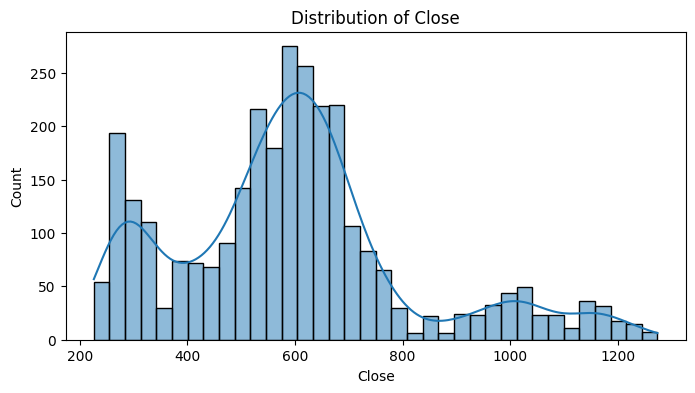

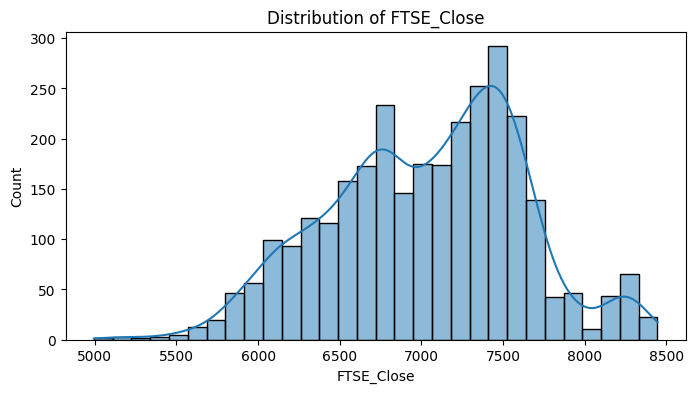

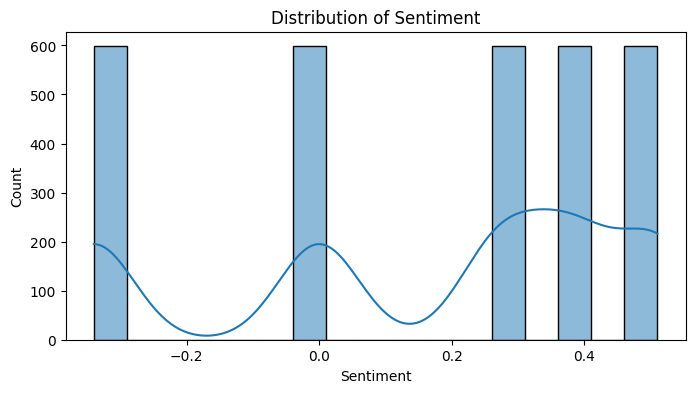

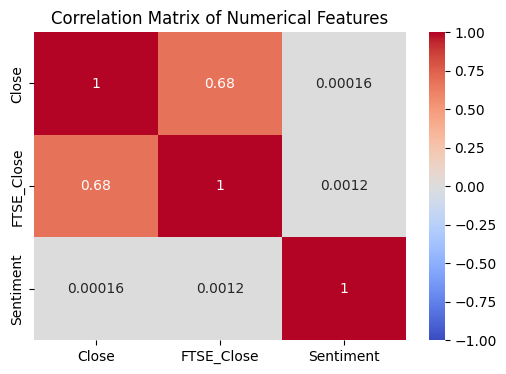

In [14]:
# Step 4: Exploratory Data Analysis (EDA)
print("Basic Information of stock_ticker:")
print(stock_ticker.info())

# Check for missing values
print("\nMissing Values in tickerDf:")
print(stock_ticker.isna().sum())

# Display summary statistics
print("\nSummary Statistics of Numerical Features:")
print(stock_ticker.describe())

# Check for duplicate rows
duplicates = stock_ticker.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Visualize distributions of numerical columns
numerical_columns_in_stock_ticker = ['Close', 'FTSE_Close', 'Sentiment']
for col in numerical_columns_in_stock_ticker:
    plt.figure(figsize=(8, 4))
    sns.histplot(stock_ticker[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Check correlation between numerical columns
correlation_matrix_for_stock_ticker = stock_ticker[numerical_columns_in_stock_ticker].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix_for_stock_ticker, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


# Step 4: Exploratory Data Analysis (EDA)

In order to comprehend the structure of the `stock_ticker` DataFrame, identify any problems with data quality, and investigate the correlations between important variables, we do Exploratory Data Analysis (EDA) on it in this phase.

1. **Basic Information of DataFrame:** Using `stock_ticker.info()`, we show the basic data of `stock_ticker`. This helps determine the data kinds and completeness by giving a summary of the DataFrame structure, including column names, data types, and non-null counts.

2. **Check for Missing Values:** We use stock_ticker.isna().sum() to check the number of missing data in each column. This assists us in determining which columns require attention due to missing data.

3. **Summary Statistics of Numerical Features:** To obtain information about the distribution, mean, median, and other statistical characteristics of the data, we use the'stock_ticker.describe' function to display summary statistics of numerical columns.

4. **Check for Duplicate Rows:** We check for any duplicate rows in the dataset, which could indicate data redundancy.


5. **Visualize Distributions of Numerical Columns:** We visualise the distribution of numerical columns ({Close`, `FTSE_Close`, and `Sentiment`) using Seaborn's `histplot`. A Kernel Density Estimate (KDE) is included in every distribution plot to produce a smoother distribution curve and provide information about the skewness and range of these features.

6. **Correlation Analysis:** To investigate the connections between `Close`, `FTSE_Close`, and `Sentiment`, we generate a heatmap of the correlation matrix for the numerical characteristics. With values around 1 or -1 signifying high positive or negative correlations, respectively, this visual representation of correlations aids in our understanding of the relationship between these variables.


In [15]:
# Step 5: Feature Scaling
feature_scaler = StandardScaler()
stock_ticker[['FTSE_Close', 'Sentiment']] = feature_scaler.fit_transform(stock_ticker[['FTSE_Close', 'Sentiment']])

# Step 5: Feature Scaling

In this stage, we use the `StandardScaler` from Scikit-Learn to apply feature scaling to the `FTSE_Close` and `Sentiment` columns in the `stock_ticker` DataFrame. The characteristics are transformed by standard scaling to have a standard deviation of one and a mean of zero. This procedure guarantees that each feature contributes proportionately during training, which is crucial for models like neural networks that are sensitive to the scale of features.

1. **Initialize the Scaler:** We create an instance of `StandardScaler`, which is suitable for data that is approximately normally distributed.
   
2. **Fit and Transform Data:** We apply the scaler to the `FTSE_Close` and `Sentiment` columns, scaling these features and replacing the original values with their scaled counterparts.

In [16]:
# Step 6: Feature Engineering
stock_ticker['MA_10'] = stock_ticker['Close'].rolling(window=10).mean().fillna(method='bfill')
stock_ticker['Volatility'] = stock_ticker['Close'].rolling(window=10).std().fillna(method='bfill')

/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_48123/2082053770.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_ticker['MA_10'] = stock_ticker['Close'].rolling(window=10).mean().fillna(method='bfill')
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_48123/2082053770.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_ticker['Volatility'] = stock_ticker['Close'].rolling(window=10).std().fillna(method='bfill')


# Step 6: Feature Engineering

In this step, we perform feature engineering on the `stock_ticker` DataFrame by creating two new features: a moving average (MA) and volatility.

1. **10-Day Moving Average (MA_10):** The `Close` price's 10-day moving average is computed to emphasise longer-term trends and even out short-term swings. Understanding recent price movements is made easier with this feature, which could have an impact on stock forecasting models. Backward fill (`bfill`) is used to fill in the initial missing values (caused by the window size).

2. **10-Day Volatility:** The rolling standard deviation of the `Close` price over a 10-day period is used to calculate volatility. This characteristic indicates times of high or low price stability and shows the extent of stock price fluctuation. Backward fill is used to fill in any missing numbers, just like with the moving average.

In [17]:

# Step 7: Splitting the Data
training_data_size = int(len(stock_ticker) * 0.8)
training_data = stock_ticker.iloc[:training_data_size]
testing_data  = stock_ticker.iloc[training_data_size:]

# Prophet Model Setup with Actual Prices for 'Close'
data_frame_prophet = stock_ticker.reset_index()[['Date', 'Close']]
data_frame_prophet.columns = ['ds', 'y']

# Initialize and fit the Prophet model
Prophet_model = Prophet()
Prophet_model.fit(data_frame_prophet)

19:47:30 - cmdstanpy - INFO - Chain [1] start processing
19:47:30 - cmdstanpy - INFO - Chain [1] done processing


### Step 7: Splitting the Data and Prophet Model Setup

In this step, we split the dataset into training and testing subsets, prepare the data for the Prophet model, and then initialize and fit the model:

1. **Data Splitting:**  
   We split the `stock_ticker` DataFrame into training and testing sets using an 80/20 split.
   - The `training_data` contains the first 80% of the dataset.
   - The `testing_data` contains the remaining 20% of the dataset.
   This split ensures that the model is trained on a substantial portion of the data and tested on unseen data for performance evaluation.
2. **Data Preparation for Prophet Model:**
   Prophet requires a specific format, with columns ds for date and y for the target variable. Therefore, we reset the index of `stock_ticker`, selecting only the Date and Close columns, and rename them to ds and y respectively.
3. **Initialize and Fit the Prophet Model:**
   We initialize the Prophet model and fit it on 'data_frame_prophet'. This model configuration will allow us to forecast the stock prices based on historical Close price data.

 


In [18]:

# Step 8: Forecasting Future Values
future = Prophet_model.make_future_dataframe(periods=365)
forecast = Prophet_model.predict(future)


### Step 8: Forecasting Future Values

In this step, we extend the time frame of the data and use the Prophet model to make predictions for future stock prices:

1. **Creating a Future DataFrame:**
   - We use the `make_future_dataframe` method of Prophet to create a new DataFrame called `future`, which extends the date range by an additional 365 days beyond the original dataset. This enables the model to forecast stock prices for the next year.
2. **Generating Predictions:** 
The predicted values are produced by applying the trained Prophet model to the future DataFrame using the predict method 'Prophet_model.predict'. For every date in the expanded time frame, the forecasts, including trend and seasonal components, are included in the resulting forecast DataFrame.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


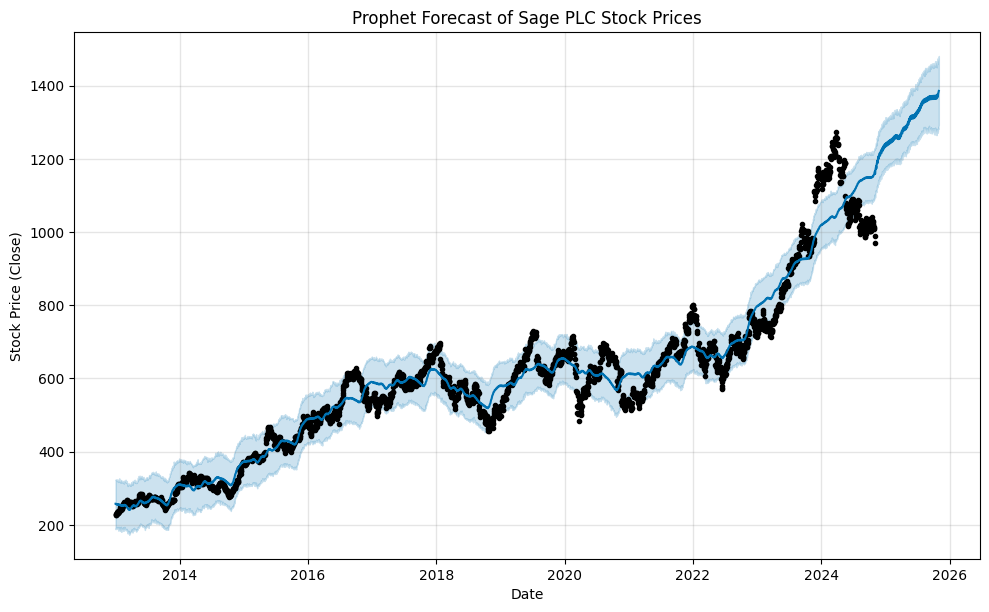

In [19]:

# Step 9: Plot the forecast with actual close prices
fig1 = Prophet_model.plot(forecast)
plt.title('Prophet Forecast of Sage PLC Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (Close)')
plt.show()

### Step 9: Plot the Forecast with Actual Close Prices

In this step, we visualize the forecast generated by the Prophet model alongside the actual historical close prices for Sage PLC:

1. **Plotting the Forecast:**
We plot the predicted stock prices using Prophet's built-in plotting function, `plot`. This covers the extended forecast for the upcoming 365 days as well as the previous data.
2. **Adding Plot Titles and Labels:**

For clarity, we call the x-axis "Date" and the y-axis "Stock Price (Close)" and set the plot's caption to "Prophet Forecast of Sage PLC Stock Prices."

In [20]:

# Step 10: Merge the test set with the forecast
testing_data = testing_data.reset_index()
test_data_for_forecasting = forecast[['ds', 'yhat']]
test_data_for_forecasting.columns = ['Date', 'Predicted_Close']
merged_test_data_for_forecasting = pd.merge(testing_data, test_data_for_forecasting, how='inner', on='Date')

### Step 10: Merge the Test Set with the Forecast

In this step, we combine the actual test set data with the forecasted values to facilitate a comparison between the Prophet model's predictions and the actual close prices:

1. **Reset the Index for Testing Data:**
   - We reset the index of the `testing_data` DataFrame to ensure that it has a column-based index, facilitating the merge operation.
2. **Prepare Forecast Data for Merging:**
Select only the ds (date) and yhat (forecasted close price) columns from the forecast DataFrame, renaming them to Date and Predicted_Close for clarity. 
3. **Merge Forecast and Test Data:**
To align the actual test set data with the anticipated close prices, perform an inner join on the Date column. This will create a merged DataFrame (merged_test_data_for_forecasting) that compares the actual and forecasted values.By comparing the Close (actual) and Predicted_Close (forecasted) values across the test period, the combined DataFrame will be helpful in assessing the model's prediction accuracy.

In [21]:
# Step 11 Evaluation Metrics for Regression
y_true = merged_test_data_for_forecasting['Close'].values
y_pred = merged_test_data_for_forecasting['Predicted_Close'].values

### Step 11: Evaluation Metrics for Regression

In this step, we prepare the actual (`y_true`) and predicted (`y_pred`) stock prices for calculating regression evaluation metrics:

1. **Extract Actual Close Prices:**
   - The `Close` column in the `merged_test_data_for_forecasting` DataFrame contains the actual stock prices, which are extracted into `y_true` as a NumPy array.
   
   ```python
   y_true = merged_test_data_for_forecasting['Close'].values
2. **Extract Predicted Close Prices:** 
The predicted stock prices produced by the Prophet model are extracted into y_pred as a NumPy array and are stored in the Predicted_Close column of the merged_test_data_for_forecasting DataFrame.To assess the predictive performance of the model, these arrays, y_true and y_pred, will be utilised to calculate a number of regression measures, including RMSE, MAE, and R-squared.

In [22]:

# Step 12 Calculate RMSE, MAE, and additional metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
msle = np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)
r2 = r2_score(y_true, y_pred)

print(f"Root Mean Square Error(RMSE): {rmse:.4f}")
print(f"Mean Absolute Error(MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error(MAPE): {mape:.2f}%")
print(f"Mean Squared Logarithmic Error(MSLE): {msle:.4f}")
print(f"R-squared: {r2:.4f}")

Root Mean Square Error(RMSE): 87.0717
Mean Absolute Error(MAE): 69.0974
Mean Absolute Percentage Error(MAPE): 7.12%
Mean Squared Logarithmic Error(MSLE): 0.0073
R-squared: 0.7698


### Step 12: Calculate RMSE, MAE, and Additional Metrics

In this step, we calculate various evaluation metrics to assess the Prophet model's performance on the test data:

1. **Root Mean Square Error (RMSE):**
    Larger errors are penalised more severely by RMSE, which calculates the average magnitude of the prediction errors. Better model performance is shown by a lower RMSE.
2. **Mean Absolute Error (MAE):**
    The average absolute difference between expected and actual values is determined by MAE. It offers a simple way to interpret the average forecast error.
3.  **Mean Absolute Percentage Error (MAPE):**
    We can comprehend the inaccuracy in relation to the actual data thanks to MAPE, which expresses the error as a percentage. Better prediction accuracy is shown by lower MAPE values.    
4. **Mean Squared Logarithmic Error (MSLE):**
    In situations where data values vary widely, MSLE is helpful for capturing the relative error between predictions and actual values and penalising bigger underestimations.   
5. **R-squared (R²):**
    A number nearer 1 indicates a better fit to the data. R-squared quantifies the percentage of variation explained by the model.
6. **Print the Results:**
    Show the computed metrics for comparison and analysis. These metrics offer a thorough assessment of the model's precision and capacity to identify patterns in forecasts of stock prices.

In [23]:
# Step 13 Symmetric Mean Absolute Percentage Error (sMAPE)
sMAPE = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100
print(f"Symmetric Mean Absolute Percentage Error(sMAPE): {sMAPE:.2f}%")

# Directional Accuracy
merged_test_data_for_forecasting['Actual_Direction'] = (merged_test_data_for_forecasting['Close'].diff() > 0).astype(int)
merged_test_data_for_forecasting['Predicted_Direction'] = (merged_test_data_for_forecasting['Predicted_Close'].diff() > 0).astype(int)

merged_test_data_for_forecasting = merged_test_data_for_forecasting.dropna(subset=['Actual_Direction', 'Predicted_Direction'])

precision = precision_score(merged_test_data_for_forecasting['Actual_Direction'], merged_test_data_for_forecasting['Predicted_Direction'])
recall = recall_score(merged_test_data_for_forecasting['Actual_Direction'], merged_test_data_for_forecasting['Predicted_Direction'])
accuracy = accuracy_score(merged_test_data_for_forecasting['Actual_Direction'], merged_test_data_for_forecasting['Predicted_Direction'])
f1 = f1_score(merged_test_data_for_forecasting['Actual_Direction'], merged_test_data_for_forecasting['Predicted_Direction'])

print("\nDirectional Accuracy Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Symmetric Mean Absolute Percentage Error(sMAPE): 7.10%

Directional Accuracy Metrics:
Accuracy: 0.5050
Precision: 0.5089
Recall: 0.8459
F1 Score: 0.6355


### Step 12: Calculate RMSE, MAE, and Additional Metrics

In this step, we calculate various evaluation metrics to assess the Prophet model's performance on the test data:

1. **Root Mean Square Error (RMSE):**
   - RMSE measures the average magnitude of the prediction errors, penalizing larger errors more heavily. A lower RMSE indicates better model performance.
   ```python
   rmse = np.sqrt(mean_squared_error(y_true, y_pred))
2. Mean Absolute Error (MAE):

MAE calculates the average absolute difference between predicted and actual values. It provides a straightforward interpretation of the average error in predictions.
3.Mean Absolute Percentage Error (MAPE):

MAPE expresses the error as a percentage, allowing us to understand the error relative to the actual values. Lower MAPE values indicate better predictive accuracy.
4.Mean Squared Logarithmic Error (MSLE):

MSLE is useful for penalizing larger underestimations and capturing the relative error between predictions and actual values, especially in cases with wide-ranging data values.

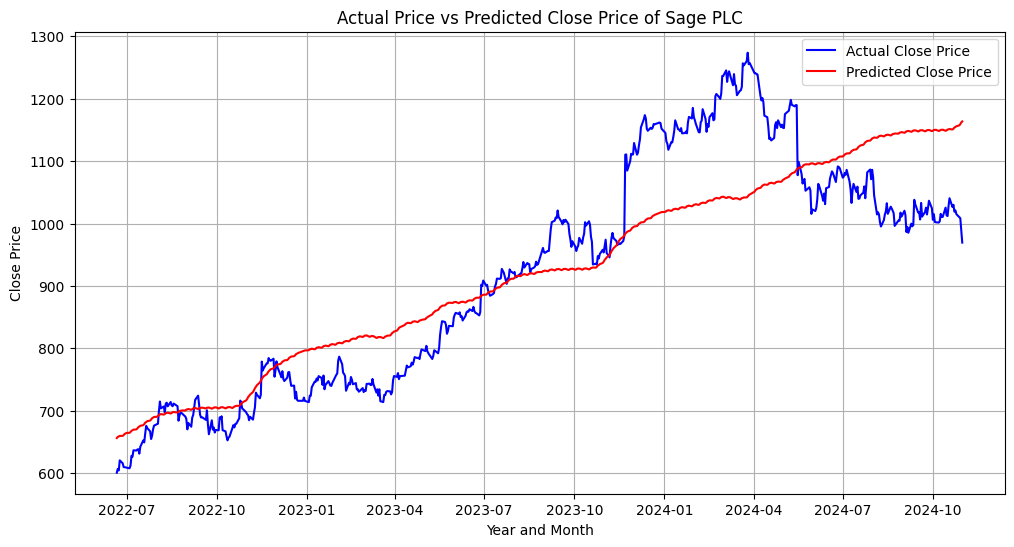

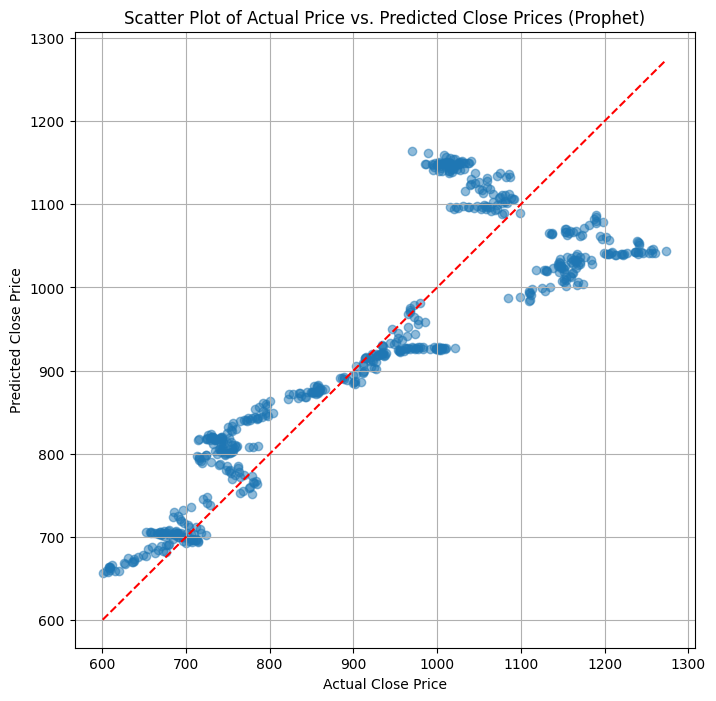

In [24]:

#Step 14 Line Plot for Actual vs. Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(merged_test_data_for_forecasting['Date'], merged_test_data_for_forecasting['Close'], label='Actual Close Price', color='blue')
plt.plot(merged_test_data_for_forecasting['Date'], merged_test_data_for_forecasting['Predicted_Close'], label='Predicted Close Price', color='red')
plt.title("Actual Price vs Predicted Close Price of Sage PLC")
plt.xlabel("Year and Month")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

# Scatter Plot for Actual vs. Predicted Prices
plt.figure(figsize=(8, 8))
plt.scatter(merged_test_data_for_forecasting['Close'], merged_test_data_for_forecasting['Predicted_Close'], alpha=0.5)
plt.title("Scatter Plot of Actual Price vs. Predicted Close Prices (Prophet)")
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.grid()
plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]19:47:31 - cmdstanpy - INFO - Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 1/18 [00:00<00:03,  4.30it/s]19:47:32 - cmdstanpy - INFO - Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/18 [00:00<00:03,  4.28it/s]19:47:32 - cmdstanpy - INFO - Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 3/18 [00:00<00:03,  4.53it/s]19:47:32 - cmdstanpy - INFO - Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 4/18 [00:00<00:02,  5.14it/s]19:47:32 - cmdstanpy - INFO - Chain [1] start processing
19:47:32 - cmdstanpy - INFO - Chain [1] done processing
 28%|██▊       | 5/18 [00:01<00:02,  4.85it/s]19:47:33 - cmdstanpy - INFO - Chain [1] start processing
19:47:33 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 6/18 [00:01<00:03,  3.28it/s]19:47:33


Cross-Validation Performance Metrics:
  horizon          mse       rmse        mae      mape     mdape     smape  \
0 37 days  6453.480151  80.333556  62.650113  0.095446  0.088488  0.095917   
1 38 days  6558.665153  80.985586  63.268269  0.096526  0.088782  0.097049   
2 39 days  6685.974379  81.767808  64.080118  0.097685  0.089018  0.098367   
3 40 days  7046.051424  83.940761  66.160861  0.100448  0.091382  0.101286   
4 41 days  7325.691029  85.590251  67.573658  0.102274  0.093437  0.103149   

   coverage  
0  0.294420  
1  0.290918  
2  0.288546  
3  0.268722  
4  0.258811  


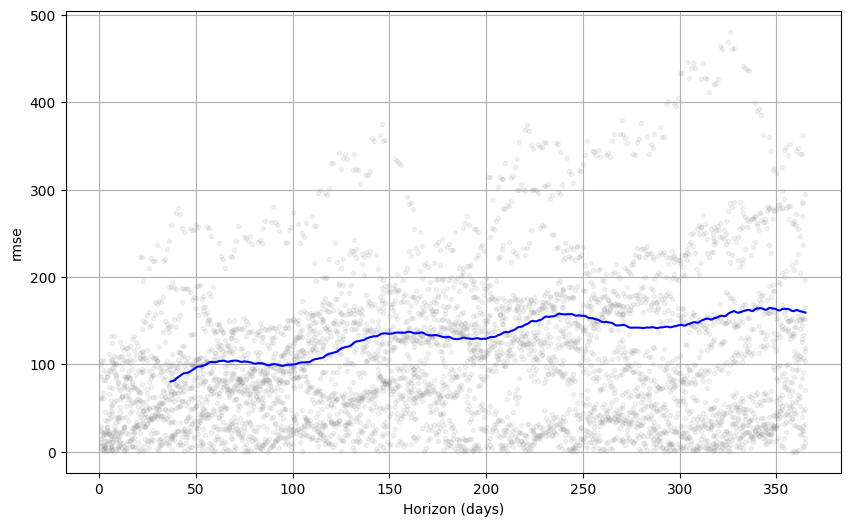

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

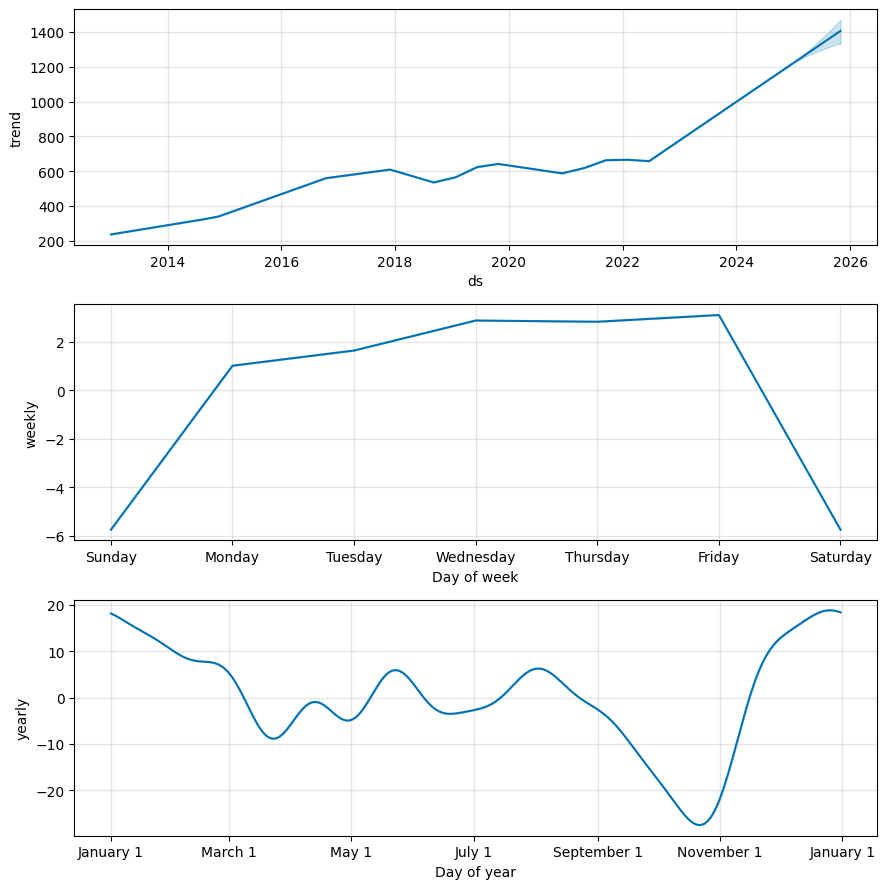

In [25]:

# Step 15: Prophet Cross-Validation and Performance Metrics
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

df_cv = cross_validation(Prophet_model, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)
print("\nCross-Validation Performance Metrics:")
print(df_p.head())

fig2 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

# Plot trend, seasonality, and holiday effects
fig2 = Prophet_model.plot_components(forecast)
plt.show()